In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mpl_finance as mpf
import matplotlib
import numpy as np
import datetime

In [2]:
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError

In [3]:
import sqlite3
from pathlib import Path

[この記事](https://blog.codecamp.jp/programming-python-stockprice)に従ってデータを受け取る．どうやら公式チュートリアルがあるようだが，どこにあるか不明．→pipのページに最低限度の使い方はあった

### 楽天の株価取得

In [11]:
#rakuten_share = share.Share("4755.T")
#rakuten_share = share.Share("^N225")
#rakuten_share = share.Share("1305.T")
rakuten_share = share.Share("1432.T")
rakuten_data = None

try:
    rakuten_data = rakuten_share.get_historical(share.PERIOD_TYPE_DAY,
                                                5,
                                                share.FREQUENCY_TYPE_MINUTE,
                                                1
                                               )

except YahooFinanceError as e:
    print(e.message)

None


### pandasのデータに変換 

timestampをutcからdatetime表記にし，それをindexにしたdataframeを作成する．

In [8]:
pandas_timestamp = [datetime.datetime.utcfromtimestamp(i/1000) for i in rakuten_data["timestamp"]]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
rakuten_df = pd.DataFrame({"Open":rakuten_data["open"],
                           "High":rakuten_data["high"],
                           "Low":rakuten_data["low"],
                           "Close":rakuten_data["close"],
                           "Volume":rakuten_data["volume"]
                          })

rakuten_df.index = pd.DatetimeIndex(pandas_timestamp)
rakuten_df.index.tz_localize('UTC')
rakuten_df.tail(5)

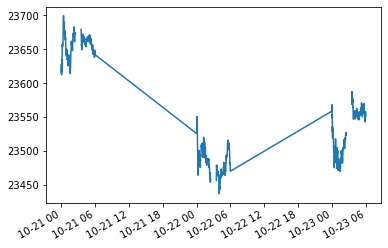

In [15]:
fig, ax = plt.subplots()
rakuten_df["Open"].plot(ax=ax)

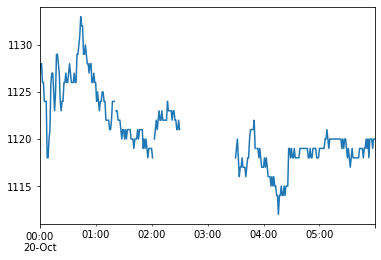

In [62]:
fig, ax = plt.subplots()
sub_df = rakuten_df["2020-10-20":"2020-10-20"]
sub_df["Open"].plot(ax=ax)

### データベースに登録 

In [63]:
db_path = Path("sample_db") / Path("sample.db")
conn = sqlite3.connect(db_path,
                       detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES
                      )

In [66]:
c = conn.cursor()
c.execute("create table stock_value(timestamp timestamp unique)")

### 各銘柄の株価カラムを追加 

In [67]:
stock_str = ['Open', 'High', 'Low', 'Close', 'Volume']
rakuten_str = [i+'_4755' for i in stock_str]
print(rakuten_str)

['Open_4755', 'High_4755', 'Low_4755', 'Close_4755', 'Volume_4755']


valuesやwhereでのプレースホルダ―の使い方が分からなかったので，for文で回す．

In [68]:
for i in rakuten_str:
    c.execute("alter table stock_value add column "+ i + " real")

In [69]:
c.execute("pragma table_info('stock_value')")
col_list = c.fetchall()
print(col_list)

[(0, 'timestamp', 'timestamp', 0, None, 0), (1, 'Open_4755', 'real', 0, None, 0), (2, 'High_4755', 'real', 0, None, 0), (3, 'Low_4755', 'real', 0, None, 0), (4, 'Close_4755', 'real', 0, None, 0), (5, 'Volume_4755', 'real', 0, None, 0)]


### データをinsert(upsert) 

以下のようにやるのが簡単?
1. dfのカラム名を整える(Open_銘柄名など)
2. dfのto_sqlを利用

In [70]:
rename_dic = {}
for i,j in zip(rakuten_str, stock_str):
    rename_dic[j] = i

type_dict = {i:"real" for i in rakuten_str}

rename_rakuten_df = rakuten_df.rename(columns=rename_dic)

rename_rakuten_df.to_sql("stock_value",
                         con=conn,
                         if_exists="replace",
                         dtype=type_dict,
                         index=True,
                         index_label="timestamp"
                        )

In [71]:
c.execute("select * from stock_value")
result = c.fetchall()
print(result)

[(datetime.datetime(2020, 10, 19, 0, 0), 1132.0, 1143.0, 1131.0, 1142.0, 0.0), (datetime.datetime(2020, 10, 19, 0, 1), 1141.0, 1143.0, 1138.0, 1139.0, 73300.0), (datetime.datetime(2020, 10, 19, 0, 2), 1139.0, 1142.0, 1139.0, 1142.0, 45000.0), (datetime.datetime(2020, 10, 19, 0, 3), 1142.0, 1144.0, 1140.0, 1141.0, 148200.0), (datetime.datetime(2020, 10, 19, 0, 4), 1142.0, 1147.0, 1142.0, 1144.0, 71200.0), (datetime.datetime(2020, 10, 19, 0, 5), 1144.0, 1147.0, 1142.0, 1142.0, 92600.0), (datetime.datetime(2020, 10, 19, 0, 6), 1143.0, 1144.0, 1143.0, 1144.0, 43300.0), (datetime.datetime(2020, 10, 19, 0, 7), 1145.0, 1148.0, 1144.0, 1148.0, 26500.0), (datetime.datetime(2020, 10, 19, 0, 8), 1147.0, 1148.0, 1143.0, 1144.0, 35200.0), (datetime.datetime(2020, 10, 19, 0, 9), 1144.0, 1144.0, 1142.0, 1143.0, 19500.0), (datetime.datetime(2020, 10, 19, 0, 10), 1142.0, 1145.0, 1142.0, 1145.0, 30500.0), (datetime.datetime(2020, 10, 19, 0, 11), 1144.0, 1147.0, 1144.0, 1146.0, 23300.0), (datetime.dateti

### データの取得 

In [72]:
query_df = pd.read_sql_query("select * from stock_value where timestamp between ? and ?",
                             con=conn,
                             index_col="timestamp",
                             params= [datetime.datetime(2020,10,22,0,0,0), datetime.datetime(2020,10,22,23,59,59)]
                            )
query_df

,Open_4755,High_4755,Low_4755,Close_4755,Volume_4755
timestamp,,,,,
2020-10-22 00:00:00,1099.0,1099.0,1088.0,1090.0,413900.0
2020-10-22 00:01:00,1090.0,1090.0,1084.0,1085.0,118800.0
2020-10-22 00:02:00,1086.0,1089.0,1085.0,1088.0,58300.0
2020-10-22 00:03:00,1088.0,1088.0,1083.0,1083.0,89000.0
2020-10-22 00:04:00,1084.0,1086.0,1083.0,1085.0,34000.0
...,...,...,...,...,...
2020-10-22 05:55:00,1081.0,1082.0,1081.0,1082.0,3700.0
2020-10-22 05:56:00,1082.0,1082.0,1082.0,1082.0,3700.0
2020-10-22 05:57:00,1082.0,1082.0,1080.0,1080.0,141400.0


### テーブルの削除 

In [65]:
c.execute("drop table stock_value")

### デーてベースのクローズ 

In [ ]:
conn.close()